## Homework: Predictive Regression
### February 8, 2023

In [1]:
import sys
sys.version

'3.10.8 (main, Nov 24 2022, 08:09:04) [Clang 14.0.6 ]'

In [143]:
%matplotlib inline

import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
import scipy as sp
import quandl
import functools
import seaborn as sns
import plotnine as p9
import statsmodels.api as sm
import math
import csv
import datetime as dt
import statsmodels.regression.linear_model as linreg
from sklearn.metrics import r2_score

pd.options.mode.chained_assignment = None 

## Introduction

In this study, I constructed a two-stage regression for predicting hedged CDS spread returns using two methods, **boxcar and discounted least squares regression**, for the predictive phase, and compare the two.

When we are designing a trading model, we need to know how a variable compares to recent history. As data points recede into the past, however, their importance to current trading strategies declines. Boxcar and discounted least squares regression are two possible ways that could achieve such a weighting scheme.

## Data

I imported five year CDS rates for debt from several companies over a multi-year range. I also used Quandl to load the adjusted close prices for the corresponding equity, and adjusted prices of the SPY ETF.

The timeframe is **from January 1, 2018 to December 30, 2022**. 

### Functions

In [10]:
myAPIkey = "qUL_zooxYcHueGAiB-D-"
quandl.ApiConfig.api_key = myAPIkey

def get_cds_data():

    df_cds = pd.read_csv('Liq5YCDS.delim', delimiter = "\t")
    df_cds = df_cds[['date','ticker','parspread']]

    u = df_cds.groupby('date')['ticker'].agg(list)
    df_cds['ticker_list'] = df_cds['date'].map(u[u.str.len().ge(2)])

    df_cds['ticker_list'] = [','.join(map(str, l)) for l in df_cds['ticker_list']]

    print("unique ticker lists:")
    print(df_cds.ticker_list.unique())

    ticker_list = df_cds.ticker_list.iloc[0].split(",")

    df_cds = df_cds[['date','ticker','parspread']]
    df_cds = df_cds.set_index('date')

    df_cds.index = pd.to_datetime(df_cds.index)
    df_cds.parspread = df_cds.parspread.astype(float)

    return df_cds, ticker_list


def get_equity_adj_close(ticker_list,start_date,end_date):
    
    df = quandl.get_table('QUOTEMEDIA/PRICES', ticker = ticker_list[0],date = {'gte':start_date, 'lte':end_date})  
    df = df.sort_values(by='date')
    df = df[['date','adj_close']]    
    df = df.set_index(['date'])
    df = df.rename(columns={'adj_close': ticker_list[0]+'_equity'})

    for ticker in ticker_list[1:]:

        df1 = quandl.get_table('QUOTEMEDIA/PRICES', ticker = ticker,date = {'gte':start_date, 'lte':end_date})  
        df1 = df1.sort_values(by='date')
        df1 = df1.set_index(['date'])
        df[ticker+'_equity'] = df1['adj_close']

    return df


def get_spy_data(start_date,end_date):

    df_spy = quandl.get_table('QUOTEMEDIA/PRICES', ticker='SPY',date = {'gte':start_date, 'lte':end_date})

    df_spy = df_spy.sort_values(by='date')
    df_spy = df_spy[['date','adj_close']]    
    df_spy = df_spy.set_index(['date'])
    df_spy = df_spy.rename(columns={'adj_close': 'SPY'})

    return df_spy


def generate_cds_dict(df_cds,ticker_list):

    cds_return_dict = {ticker : pd.DataFrame() for ticker in ticker_list}

    for key in cds_return_dict.keys():

        cds_return_dict[key] = df_cds[:][df_cds.ticker == key]
        cds_return_dict[key] = cds_return_dict[key][['parspread']]
        cds_return_dict[key] = cds_return_dict[key].resample('W-WED').last().pct_change()
        cds_return_dict[key] = cds_return_dict[key].rename(columns={'parspread': key + '_cds'})
        cds_return_dict[key] = cds_return_dict[key].dropna()

    return cds_return_dict

### Implement

* **CDS spreads**

CDS spreads are the difference in interest rates between a government bond and a corporate bond of the same maturity, where the corporate bond is issued by a particular company. CDS spreads are an important tool for investors and lenders because they help them assess the creditworthiness of a company or entity. Higher CDS spreads indicate that a borrower is more likely to default on its debt obligations, while lower spreads indicate a lower risk of default.

The importance of CDS spreads lies in their ability to help investors and lenders evaluate and price risk. By comparing the CDS spreads of different companies, investors can assess which companies are more or less risky, and adjust their investment strategies accordingly. Additionally, CDS spreads can help lenders price loans to reflect the risk of default, which can help to ensure that lenders are adequately compensated for the risk they are taking on.

In this study, I dropped NFLX due to missing data, and focused on the remaining 14 tickers. I seperated the orginal dataset and created a dictionary to access CDS spreads data by ticker name more easily.

In [4]:
df_cds, ticker_list = get_cds_data()

unique ticker lists:
['BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,T,WFC,XOM,XRX'
 'BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,NFLX,T,WFC,XOM,XRX']


In [5]:
df_cds.head()

,ticker,parspread
date,,
2018-01-01,BA,0.001793
2018-01-01,C,0.004113
2018-01-01,DD,0.002476
2018-01-01,F,0.008805
2018-01-01,GE,0.004037


In [7]:
print(ticker_list)

['BA', 'C', 'DD', 'F', 'GE', 'JPM', 'LNC', 'LOW', 'LUV', 'MAR', 'T', 'WFC', 'XOM', 'XRX']


In [11]:
cds_return_dict = generate_cds_dict(df_cds,ticker_list)

In [19]:
cds_return_dict['BA'].head()

,BA_cds
date,
2018-01-10,-0.057555
2018-01-17,0.090416
2018-01-24,0.004652
2018-01-31,-0.016092
2018-02-07,0.217456


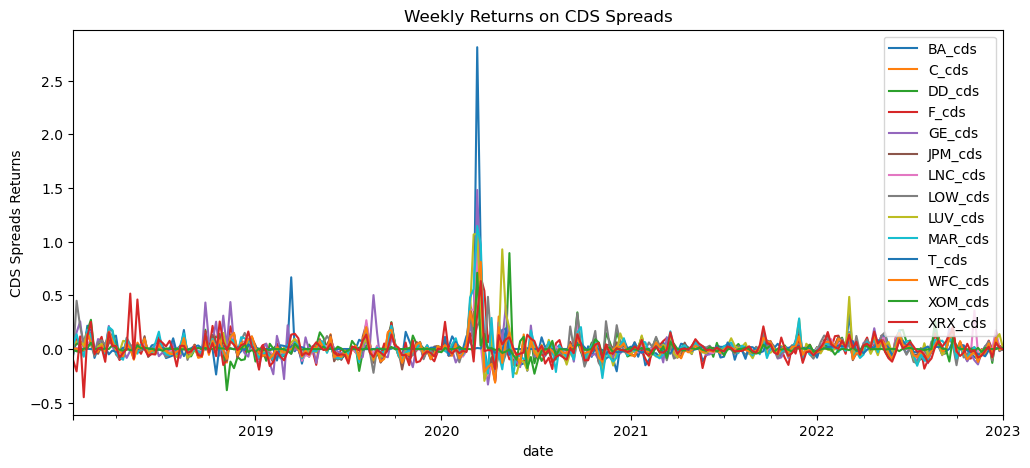

In [21]:
cds_list = []
for ticker in ticker_list:
    cds_list.append(cds_return_dict[ticker])

df_cds_return = pd.concat(cds_list,axis=1).dropna()
df_cds_return.plot(title= "Weekly Returns on CDS Spreads", ylabel = "CDS Spreads Returns" ,figsize = (12,5));

* **Equity adjusted close prices**

The corresponding adjusted close prices for the equities in tickers list are loaded, and weekly Wednesday to Wednesday returns are computed.

In [20]:
start_date = '2018-01-01'
end_date = '2022-12-30'

df_adj_close = get_equity_adj_close(ticker_list,start_date,end_date)

df_equity_return = df_adj_close.resample('W-WED').last().pct_change()
df_equity_return = df_equity_return.dropna()

df_equity_return.head()

,BA_equity,C_equity,DD_equity,F_equity,GE_equity,JPM_equity,LNC_equity,LOW_equity,LUV_equity,MAR_equity,T_equity,WFC_equity,XOM_equity,XRX_equity
date,,,,,,,,,,,,,,
2018-01-10,0.075420,0.014211,0.015743,0.021160,0.042920,0.025506,0.071882,0.023364,-0.030042,0.009161,-0.014385,0.025341,-0.007151,0.034777
2018-01-17,0.096016,0.024058,0.021159,-0.065234,-0.083417,0.024853,0.002295,0.079749,0.049396,0.031227,0.006281,0.012041,0.022305,0.051730
2018-01-24,-0.046494,0.025558,0.003167,-0.010673,-0.052450,0.023719,0.004338,0.053585,-0.058423,0.016831,0.004613,0.025047,0.006023,0.013784
2018-01-31,0.058801,-0.012209,-0.005657,-0.066703,-0.016423,0.000000,-0.006479,-0.018647,-0.022665,0.020431,0.011615,0.004582,-0.013894,0.054697
2018-02-07,-0.017637,-0.040500,-0.065890,-0.019143,-0.056895,-0.024207,-0.051812,-0.045928,-0.047862,-0.052260,-0.013885,-0.120058,-0.118671,-0.086434


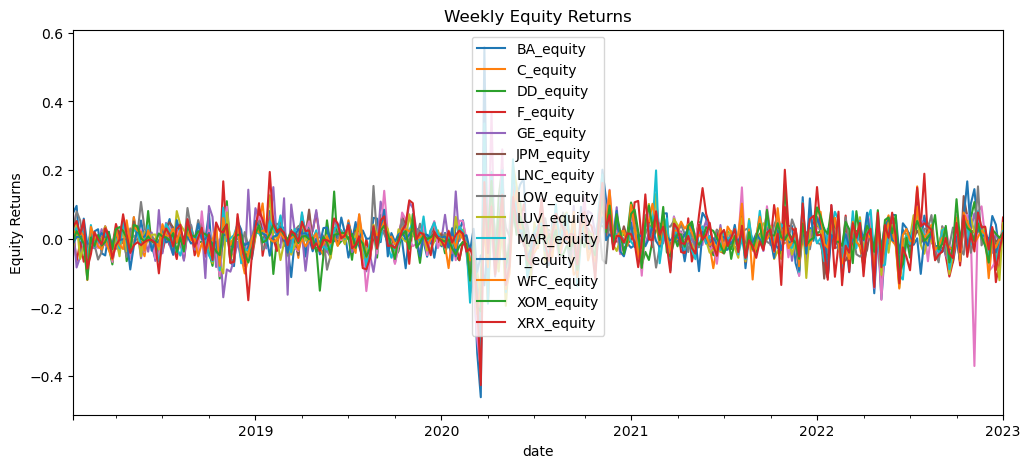

In [22]:
df_equity_return.plot(title= "Weekly Equity Returns", ylabel = "Equity Returns" ,figsize = (12,5));

* **Market equity returns**

SPY is designed to mimic the performance of the S&P 500 Index, which is a broad representation of the U.S. equity market. Because the S&P 500 Index is widely considered to be a benchmark for the U.S. stock market, SPY is often used as a way to track the performance of the market. As an ETF, SPY is traded on stock exchanges like a stock, and its price fluctuates throughout the trading day based on the performance of the underlying index.

In [23]:
df_spy = get_spy_data(start_date,end_date)

In [24]:
df_market_equity_return = df_spy.resample('W-WED').last().pct_change()
df_market_equity_return = df_market_equity_return.dropna()
df_market_equity_return.head()

,SPY
date,
2018-01-10,0.013495
2018-01-17,0.020028
2018-01-24,0.012768
2018-01-31,-0.004520
2018-02-07,-0.050479


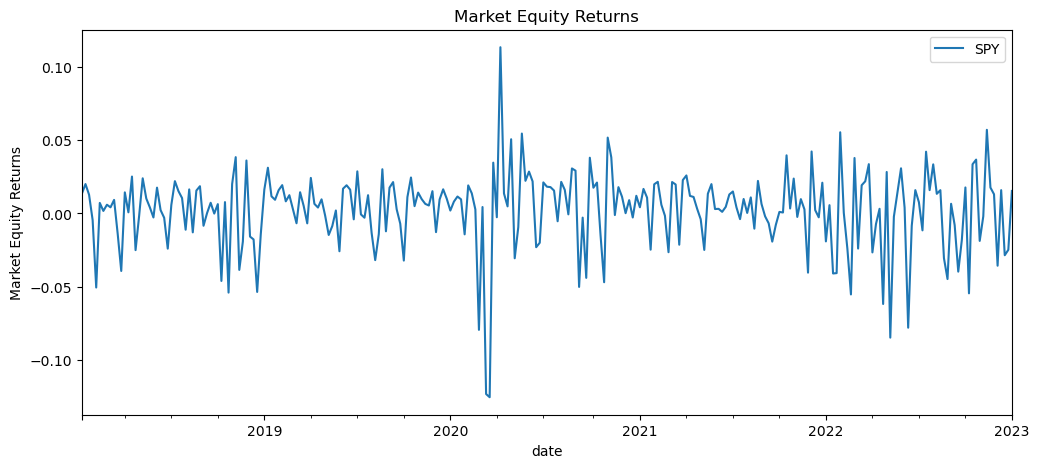

In [25]:
df_market_equity_return.plot(title= "Market Equity Returns", ylabel = "Market Equity Returns" ,figsize = (12,5));

* **Index return**

Index return is the arithmetic average of CDS spreads return.

In [26]:
df_cds_return['Index'] = df_cds_return.mean(axis=1)

df_index_return = df_cds_return[['Index']]
df_index_return.head()

,Index
date,
2018-01-10,-0.008112
2018-01-17,0.057464
2018-01-24,0.054817
2018-01-31,-0.031041
2018-02-07,0.112337


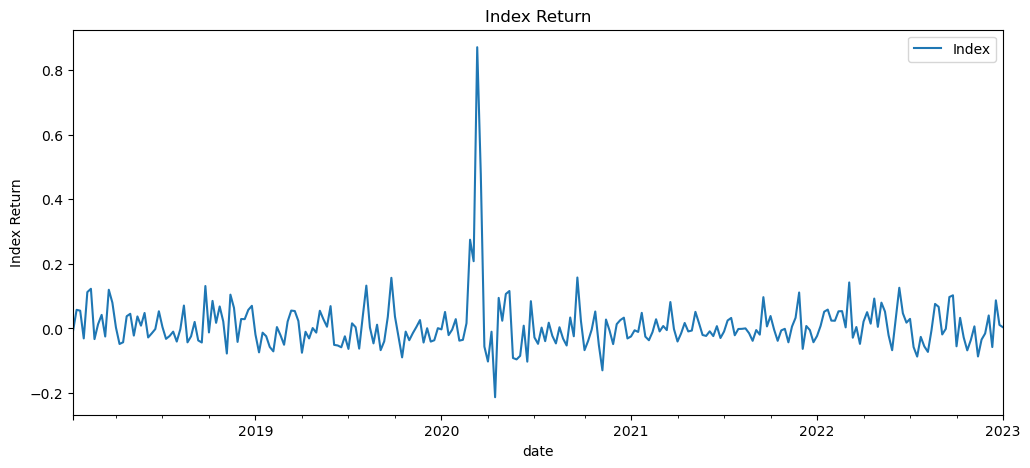

In [27]:
df_index_return.plot(title= "Index Return", ylabel = "Index Return" ,figsize = (12,5));

Above datasets are combined as below.

In [28]:
df_data_dict = {}

for ticker in ticker_list:

    df_data = pd.concat([cds_return_dict[ticker], df_equity_return[ticker+'_equity'],df_market_equity_return,df_index_return], axis=1).dropna()
    df_data_dict[ticker] = df_data

df_data_dict['BA'].head()

,BA_cds,BA_equity,SPY,Index
date,,,,
2018-01-10,-0.057555,0.075420,0.013495,-0.008112
2018-01-17,0.090416,0.096016,0.020028,0.057464
2018-01-24,0.004652,-0.046494,0.012768,0.054817
2018-01-31,-0.016092,0.058801,-0.004520,-0.031041
2018-02-07,0.217456,-0.017637,-0.050479,0.112337


## Predictive Regression Model

Predictive regression is a statistical technique used in quantitative finance and economics to analyze the relationship between a predictor variable and a dependent variable. The goal of predictive regression is to estimate the strength and direction of the relationship between the predictor and the dependent variable, and use this information to make predictions about future values of the dependent variable.

In quantitative strategy research, predictive regression is an important tool for developing and testing trading strategies. By analyzing the relationship between market variables and asset prices, researchers can identify patterns and trends that may be useful in predicting future market movements, and develop trading strategies that can potentially generate excess returns.

#### Functions

In [31]:
def reg1(df,ticker):

    p = linreg.OLS(df[ticker+'_equity'], df['SPY']).fit(params_only=True).params
    return pd.DataFrame(data=[p], index=[df.index[-1]])

def boxcar_reg1(df,K,ticker):

    b_coeffs = pd.concat([reg1(df.iloc[i-K:i],ticker) for i in range(K, df.shape[0])])
    return b_coeffs

In [32]:
def reg2(df,ticker):

    p = linreg.OLS(df[ticker+'_cds'], df[[ticker+'_equity','Index']]).fit(params_only=True).params
    return pd.DataFrame(data=[p], index=[df.index[-1]])

def boxcar_reg2(df,K,ticker):

    b_coeffs = pd.concat([reg2(df.iloc[i-K:i],ticker) for i in range(K, df.shape[0])])
    return b_coeffs

In [162]:
def reg3(df,ticker):

    p = linreg.OLS(df['\u03C1'], df['c_1']).fit(params_only=True).params
    return pd.DataFrame(data=[p], index=[df.index[-1]])

def boxcar_reg3(df_box_dict, ticker_list, K):

    for ticker in ticker_list:

        b_coeffs = pd.concat([reg3(df_box_dict[ticker].iloc[i-K:i],ticker) for i in range(K, df_box_dict[ticker].shape[0])])
        df_box_dict[ticker]['\u03BC' + '_1_' +str(K)] = b_coeffs['c_1'] 
        df_box_dict[ticker]['predict_'+'\u03C1'+'_'+str(K)] = df_box_dict[ticker]['\u03BC'+'_1_'+str(K)] * df_box_dict[ticker]['c_1']
        df_box_dict[ticker]['q_'+str(K)] = df_box_dict[ticker]['\u03C1'] - df_box_dict[ticker]['predict_'+'\u03C1'+'_'+str(K)]

    return df_box_dict

def predictive_boxcar(df_data_dict, ticker_list, K_list):

    df_box_dict = {}

    for ticker in ticker_list:

        df_box_dict[ticker] = df_data_dict[ticker][['resid_ret','resid_equity_ret_1']]
        df_box_dict[ticker] = df_box_dict[ticker].rename(columns={'resid_ret': '\u03C1','resid_equity_ret_1':'c_1'})

    for K in K_list:
        df_box_dict = boxcar_reg3(df_box_dict, ticker_list, K)

    df_box_q = pd.DataFrame(columns = ticker_list, index=K_list)

    for ticker in ticker_list:
        for K in K_list:

            df_temp = df_box_dict[ticker][['\u03C1','predict_'+'\u03C1'+'_'+str(K)]].dropna()
            # print(len(df_temp))

            # df_box_q[ticker][K] = float(df_box_dict[ticker][['q_' + str(K)]].dropna().pow(2).sum())
            # print(len(df_box_dict[ticker].dropna()['\u03C1']))
            df_box_q[ticker][K] = r2_score(df_temp['\u03C1'], df_temp['predict_'+'\u03C1'+'_'+str(K)])

    return df_box_dict, df_box_q

In [219]:
def exp_coeff(df, exp_1p2_wts):

    n = min(exp_1p2_wts.shape[0], df.shape[0])
    ldf = df.iloc[-n:]
    wt = exp_1p2_wts[-n:]
    p = linreg.WLS(ldf['\u03C1'], ldf['c_1'], weights = wt).fit(params_only = True).params
    
    return pd.DataFrame(data=[p], index=[df.index[-1]])


def exp_reg(df, half_life):

    lma = 2**(-1./half_life)
    threshold = 1. / (df.shape[0]* 500)

    w12 = lma**np.arange(df.shape[0]-1, -1, -1)
    exp_1p2_wts = w12[w12 > threshold]

    enough_points = np.where(w12 > 1./20)[0].shape[0]
    
    coeffs = pd.concat([exp_coeff(df.iloc[max(0,i-exp_1p2_wts.shape[0]):i], exp_1p2_wts) for i in range(enough_points, df.shape[0])])
    coeffs = coeffs.rename(columns={'c_1': '\u03BC'+'_1_'+str(half_life)})

    df = df.join(coeffs)
    # df = df.dropna()

    # print(df)
    
    df['predict_'+'\u03C1'+'_'+str(half_life)] = df['\u03BC'+'_1_'+str(half_life)] * df['c_1']
    df['q_'+str(half_life)] = df['\u03C1'] - df['predict_'+'\u03C1'+'_'+str(half_life)]

    return df


def predictive_exponential(df_data_dict, ticker_list, half_life_list):

    df_exp_dict = {}

    for ticker in ticker_list:

        df_exp_dict[ticker] = df_data_dict[ticker][['resid_ret','resid_equity_ret_1']]
        df_exp_dict[ticker] = df_exp_dict[ticker].rename(columns={'resid_ret': '\u03C1','resid_equity_ret_1':'c_1'})

        for hf in half_life_list:
            df_exp_dict[ticker] = exp_reg(df_exp_dict[ticker], half_life = hf)

    # return df_exp_dict

    df_exp_q = pd.DataFrame(columns = ticker_list, index = half_life_list)

    for ticker in ticker_list:
        for hf in half_life_list:

            df_temp = df_exp_dict[ticker][['\u03C1','predict_'+'\u03C1'+'_'+str(hf)]].dropna()
            df_exp_q[ticker][hf] = r2_score(df_temp['\u03C1'], df_temp['predict_'+'\u03C1'+'_'+str(hf)])

    return df_exp_dict, df_exp_q

In [264]:
def performance_metrics(df_compare,df_box_q,df_exp_q):

    # box_resid = df_compare[['\u03BC'+'_1_box']].dropna()
    # exp_resid = df_compare[['\u03BC'+'_1_exp']].dropna()

    box_resid = df_compare[['q_box']].dropna()
    exp_resid = df_compare[['q_exp']].dropna()
        
    metrics = pd.DataFrame(index = ['Count','Mean','Vol','Skewness','Kurtosis','R-squared'],columns= ['Boxbar (K = 10)','Discounted Least Squares (Half life = 9)'])

    metrics['Boxbar (K = 10)']['Count'] = len(box_resid)
    metrics['Discounted Least Squares (Half life = 9)']['Count'] = len(exp_resid)

    metrics['Boxbar (K = 10)']['Mean'] = float(box_resid.mean())
    metrics['Discounted Least Squares (Half life = 9)']['Mean'] = float(exp_resid.mean())

    metrics['Boxbar (K = 10)']['Vol'] = float(box_resid.std())
    metrics['Discounted Least Squares (Half life = 9)']['Vol'] = float(exp_resid.std())

    metrics['Boxbar (K = 10)']['Skewness'] = float(box_resid.skew())
    metrics['Discounted Least Squares (Half life = 9)']['Skewness'] = float(exp_resid.skew())

    metrics['Boxbar (K = 10)']['Kurtosis'] = float(box_resid.kurtosis())
    metrics['Discounted Least Squares (Half life = 9)']['Kurtosis'] = float(exp_resid.kurtosis())

    metrics['Boxbar (K = 10)']['R-squared'] = df_box_q['LUV'][10]
    metrics['Discounted Least Squares (Half life = 9)']['R-squared'] = df_exp_q['LUV'][9]

    return metrics.T

When predicting hedged CDS spread returns in this study, we use a two-stage regression. In the first part, contemporaneous regression, we only use boxcar method with a fixed window length of 16. In the second part, predictive regression, we will talk about the boxcar regression and discounted least squares regression in more details and compare their prediction performance.

### **1. Contemporaneous Regression**

A contemporaneous regression is a statistical analysis method that examines the relationship between two or more variables during the same time period. In a contemporaneous regression, the independent variables are used to predict the value of the dependent variable at the same time, or in the same time period, as the independent variables.

In the contemporaneous regression phase, we use 16 week boxcar OLS.

In [29]:
K = 16

(1) Create one contemporaneous model of the (CAPM) form and denote its weekly regression coefficients as gamma.

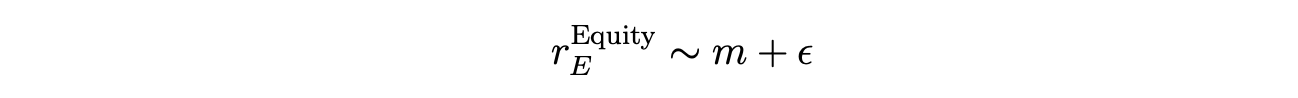

In [33]:
for ticker in ticker_list:

    df_data_dict[ticker]['Gamma'] = boxcar_reg1(df_data_dict[ticker],K,ticker)

(2) Create the following contemporaneous model and record the regression coefficients.

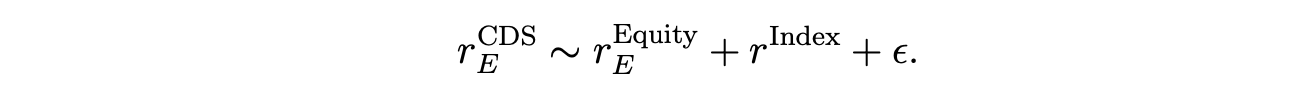

In [34]:
for ticker in ticker_list:

    df_data_dict[ticker]['beta_Equity'] = boxcar_reg2(df_data_dict[ticker],K,ticker)[ticker+'_equity']
    df_data_dict[ticker]['beta_Index'] = boxcar_reg2(df_data_dict[ticker],K,ticker)['Index']

(3) We attempt to predict the changes in CDS spreads hedged by the contemporaneous predictors. Define the hedge portfolio return as the returns on predictors in the contemporaneous model.

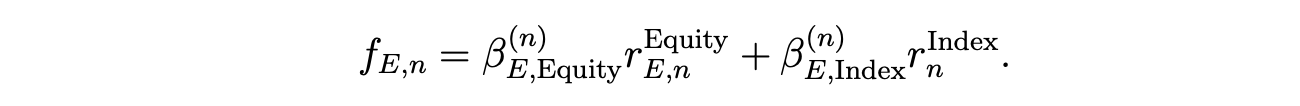

In [35]:
for ticker in ticker_list:

    df_data_dict[ticker]['f'] = df_data_dict[ticker]['beta_Equity']*df_data_dict[ticker][ticker+'_equity']+ df_data_dict[ticker]['beta_Index']*df_data_dict[ticker]['Index']

(4) Define the residual return as the residual error in the prediction.

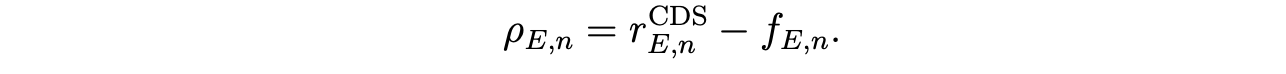

In [36]:
for ticker in ticker_list:

    df_data_dict[ticker]['resid_ret'] = df_data_dict[ticker][ticker+'_cds'] - df_data_dict[ticker]['f']

(5) Define residual equity return.

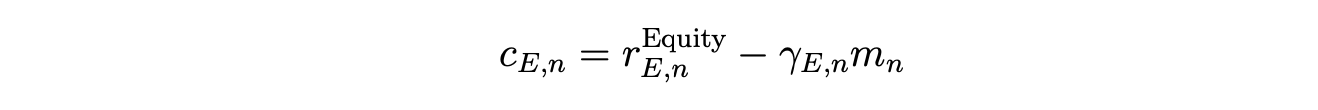

In [39]:
for ticker in ticker_list:

    df_data_dict[ticker]['resid_equity_ret'] = df_data_dict[ticker][ticker+'_equity'] - df_data_dict[ticker]['Gamma']*df_data_dict[ticker]['SPY']
    df_data_dict[ticker] = df_data_dict[ticker].dropna()

In [41]:
df_data_dict['BA'].head()

,BA_cds,BA_equity,SPY,Index,Gamma,beta_Equity,beta_Index,f,resid_ret,resid_equity_ret
date,,,,,,,,,,
2018-04-25,0.049793,0.005455,-0.025001,0.037544,0.816514,0.033503,1.445365,0.054447,-0.004654,0.025868
2018-05-02,0.035050,-0.054454,-0.001631,0.045189,0.696447,0.212908,1.441192,0.053533,-0.018482,-0.053318
2018-05-09,-0.016618,0.062648,0.023936,-0.022318,0.615251,0.288983,1.469406,-0.014690,-0.001927,0.047922
2018-05-16,-0.014942,-0.005328,0.010167,0.037028,0.702168,0.164046,1.459297,0.053161,-0.068103,-0.012467
2018-05-23,0.010934,0.053494,0.004114,0.008501,0.775872,0.079614,1.453921,0.016619,-0.005685,0.050302


### **2. Predictive Regression**

After obtaining residual return (rho) and residual equity return (c), I form predictive regression models using boxcar regression and exponentially decaying. I use the past week’s residual equity return to predict novel changes to CDS spread based on previous residual equity returns, and get the residuals of the predictive model.

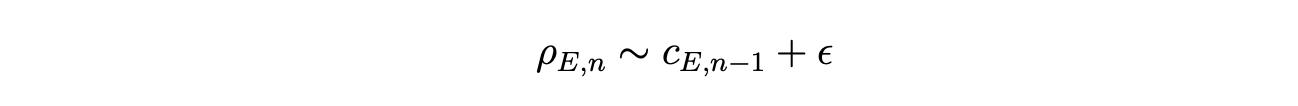

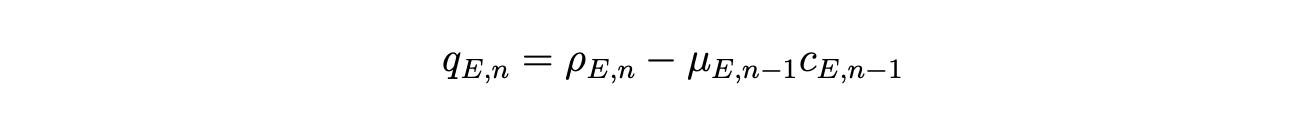

In [43]:
for ticker in ticker_list:

    df_data_dict[ticker]['resid_equity_ret_1'] = df_data_dict[ticker]['resid_equity_ret'].shift(1) 
    df_data_dict[ticker] =  df_data_dict[ticker].dropna()

In [140]:
df_data_dict['BA'][0:10]

,BA_cds,BA_equity,SPY,Index,Gamma,beta_Equity,beta_Index,f,resid_ret,resid_equity_ret,resid_equity_ret_1
date,,,,,,,,,,,
2018-05-02,0.035050,-0.054454,-0.001631,0.045189,0.696447,0.212908,1.441192,0.053533,-0.018482,-0.053318,0.025868
2018-05-09,-0.016618,0.062648,0.023936,-0.022318,0.615251,0.288983,1.469406,-0.014690,-0.001927,0.047922,-0.053318
2018-05-16,-0.014942,-0.005328,0.010167,0.037028,0.702168,0.164046,1.459297,0.053161,-0.068103,-0.012467,0.047922
2018-05-23,0.010934,0.053494,0.004114,0.008501,0.775872,0.079614,1.453921,0.016619,-0.005685,0.050302,-0.012467
2018-05-30,0.053757,-0.002840,-0.002744,0.047785,1.042388,0.074468,1.316843,0.062713,-0.008956,0.000020,0.050302
2018-06-06,-0.024662,0.037327,0.017571,-0.028040,1.138698,0.079163,1.284249,-0.033056,0.008393,0.017319,0.000020
2018-06-13,0.033754,-0.020750,0.002271,-0.015483,1.118697,0.043741,1.214597,-0.019713,0.053467,-0.023291,0.017319
2018-06-20,0.044560,-0.058156,-0.002947,-0.002083,1.126910,-0.077843,1.186664,0.002055,0.042505,-0.054835,-0.023291
2018-06-27,0.092806,-0.037556,-0.023988,0.053028,1.218409,-0.054364,1.188305,0.065056,0.027750,-0.008328,-0.054835


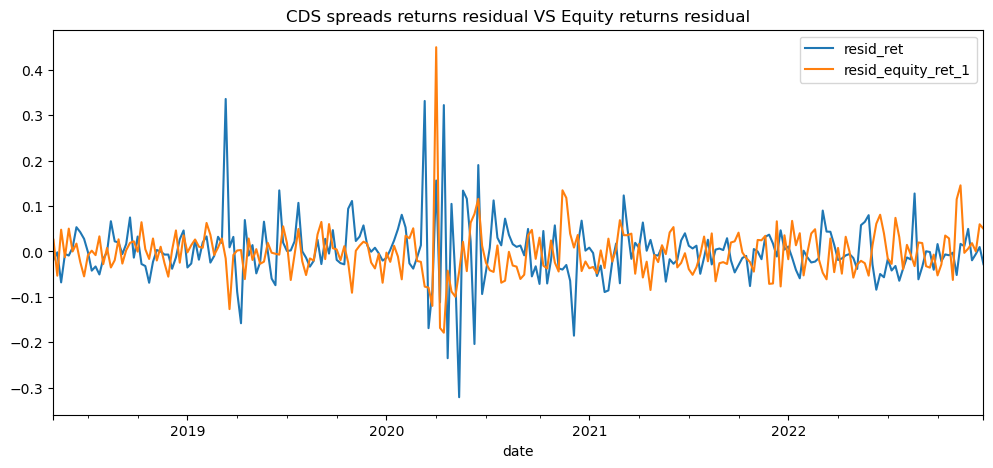

In [47]:
df_data_dict['BA'][['resid_ret','resid_equity_ret_1']].plot(title= "CDS spreads returns residual VS Equity returns residual",figsize = (12,5));

#### **---------------------------------------------------- Boxcar Regression ----------------------------------------------------**

Boxcar regression is a type of predictive regression that is commonly used in quantitative finance and economics. In boxcar regression, the predictor variable is split into a set of discrete categories or intervals, and a separate regression model is estimated for each category.

The basic idea behind boxcar regression is to capture any non-linear relationships between the predictor variable and the dependent variable. By dividing the predictor into discrete categories, the model can capture any non-linearities that may not be apparent in a linear regression model.

One of the main advantages of boxcar regression is its ability to capture non-linear relationships between the predictor variable and the dependent variable. This can be particularly useful in finance and economics, where relationships between variables can be complex and non-linear. Boxcar regression can also be more robust to outliers and extreme values than other types of regression models.

R-squared is a commonly used statistical measure to evaluate the goodness of fit of a regression model. It is the proportion of the variance in the dependent variable that can be explained by the independent variables in the regression model. The value of R-squared ranges from 0 to 1, with higher values indicating a better fit of the model to the data.

In the following discussions, I compared the R-squared of boxcar regressions when using different lengths of moving boxcar window K.

In [186]:
K_list = [10,13,16,20,25]

df_box_dict, df_box_q = predictive_boxcar(df_data_dict, ticker_list, K_list)

In [187]:
df_box_q['Mean R-squared'] = df_box_q.mean(axis=1)
df_box_q

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,T,WFC,XOM,XRX,Mean R-squared
10,0.103145,0.195853,0.074514,0.186389,0.138613,0.115236,0.165509,0.351074,0.273318,0.133089,0.037758,0.120441,0.073207,0.144706,0.150918
13,0.099853,0.187083,0.077754,0.17965,0.113456,0.109077,0.156375,0.335225,0.229188,0.165208,0.03763,0.140902,0.057185,0.097781,0.141883
16,0.093376,0.172043,0.079014,0.17073,0.097735,0.111163,0.147655,0.339287,0.227569,0.170998,0.032473,0.132451,0.050655,0.09378,0.137066
20,0.088225,0.168309,0.064069,0.145435,0.091579,0.100088,0.121019,0.332082,0.212804,0.114812,0.027557,0.117042,0.053579,0.114136,0.125052
25,0.077582,0.145367,0.054853,0.107621,0.062877,0.073003,0.088296,0.278691,0.204039,0.132744,0.018513,0.100412,0.037258,0.086894,0.104868


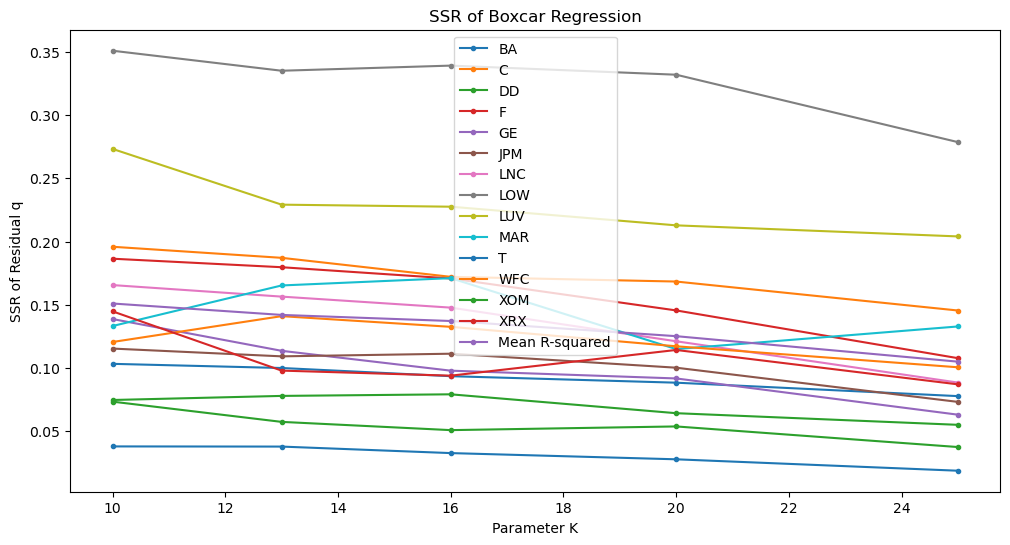

In [188]:
df_box_q.plot(title= "SSR of Boxcar Regression", ylabel = "SSR of Residual q", xlabel = "Parameter K", figsize = (12,6),style='.-');

According to the above result, we could find out that in general for all tickers, choosing the moving boxcar window length K as 10 could achieve the highest R-squared value in boxcar regression.

#### **------------------------------------------ Discounted Least Squares Regression ------------------------------------------**

Discounted least squares regression is a technique used in quantitative finance and economics to analyze the relationship between a predictor variable and a dependent variable. DLS regression is similar to traditional least squares regression, but it incorporates a discount factor that weights more recent observations more heavily than older observations.

The basic idea behind DLS regression is that more recent data is typically more relevant for predicting future outcomes than older data. By incorporating a discount factor, DLS regression gives more weight to more recent data, which can improve the accuracy of the model's predictions.

One of the main advantages of DLS regression is its ability to capture the dynamic nature of financial and economic data. Financial markets are constantly changing, and DLS regression can help to capture these changes over time. DLS regression can also be more robust to non-stationary data than other types of regression models.

In [224]:
half_life_list = [9,10,11,12,13]

df_exp_dict, df_exp_q = predictive_exponential(df_data_dict, ticker_list, half_life_list)

In [226]:
df_exp_q['Mean R-squared'] = df_exp_q.mean(axis=1)
df_exp_q

,BA,C,DD,F,GE,JPM,LNC,LOW,LUV,MAR,T,WFC,XOM,XRX,Mean R-squared
9,0.12009,0.211455,0.07844,0.197753,0.123304,0.133544,0.168005,0.33213,0.263085,0.193118,0.063636,0.175866,0.093748,0.152012,0.164728
10,0.113379,0.201662,0.073104,0.181377,0.100108,0.125595,0.158287,0.319318,0.254546,0.187167,0.05877,0.166792,0.08735,0.147385,0.155346
11,0.117204,0.196466,0.067378,0.171944,0.094823,0.12044,0.152315,0.311015,0.245192,0.185949,0.05687,0.15926,0.083094,0.145845,0.150557
12,0.113794,0.189558,0.06585,0.161635,0.091987,0.112651,0.143973,0.300616,0.238432,0.182183,0.052593,0.150958,0.078376,0.144163,0.144769
13,0.108999,0.183227,0.058065,0.154727,0.0907,0.106489,0.135694,0.293618,0.232929,0.180068,0.048871,0.143586,0.074539,0.141924,0.139531


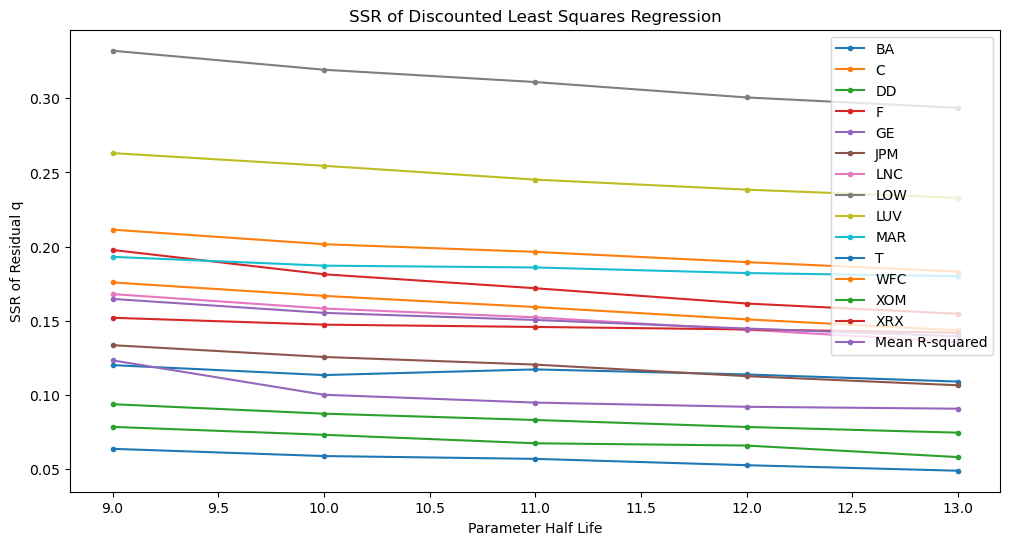

In [227]:
df_exp_q.plot(title= "SSR of Discounted Least Squares Regression", ylabel = "SSR of Residual q", xlabel = "Parameter Half Life", figsize = (12,6),style='.-');

According to the above result, choosing the half life parameter as 9 could achieve the highest R-squared value for all tickers in discounted least squares regression.

#### **Comparison** ####

In the following discussions, I choose the parameters which achieve the best prediction results in each regression, and compare the performance. 

I choose ticker LUV as an example.

In [239]:
df_box_ = df_box_dict['LUV'][['\u03C1','c_1','\u03BC'+'_1_10','predict_'+'\u03C1'+'_10','q_10']]
df_box_ = df_box_.rename(columns={'\u03BC'+'_1_10':'\u03BC'+'_1_box' ,'predict_'+'\u03C1'+'_10':'predict_'+'\u03C1'+'_box','q_10':'q_box'})

df_exp_ = df_exp_dict['LUV'][['\u03C1','c_1','\u03BC'+'_1_9','predict_'+'\u03C1'+'_9','q_9']]
df_exp_ = df_exp_.rename(columns={'\u03BC'+'_1_9':'\u03BC'+'_1_exp' ,'predict_'+'\u03C1'+'_9':'predict_'+'\u03C1'+'_exp','q_9':'q_exp'})

df_luv = df_box_.join(df_exp_[['\u03BC'+'_1_exp','predict_'+'\u03C1'+'_exp','q_exp']])

In [240]:
df_luv.tail()

,ρ,c_1,μ_1_box,predict_ρ_box,q_box,μ_1_exp,predict_ρ_exp,q_exp
date,,,,,,,,
2022-11-30,0.000113,0.001353,-0.101018,-0.000137,0.000250,-0.322071,-0.000436,0.000549
2022-12-07,-0.002593,0.021345,-0.256537,-0.005476,0.002883,-0.316043,-0.006746,0.004153
2022-12-14,-0.033114,-0.018063,-0.302156,0.005458,-0.038572,-0.267217,0.004827,-0.037941
2022-12-21,0.003614,-0.006569,-0.300744,0.001976,0.001639,-0.268133,0.001761,0.001853
2022-12-28,0.042430,-0.010932,NaN,NaN,NaN,NaN,NaN,NaN


* **Performance of predictive regressions**

In the predictive regression models that use equity return residual to predict CDS return spread residual, as seen in the figure below, there is no significant difference between the results of boxcar regression and discounted least squares regression, and both models failed to accurately predict the sharp fluctuations in CDS return spread residual in the first half of year 2020.

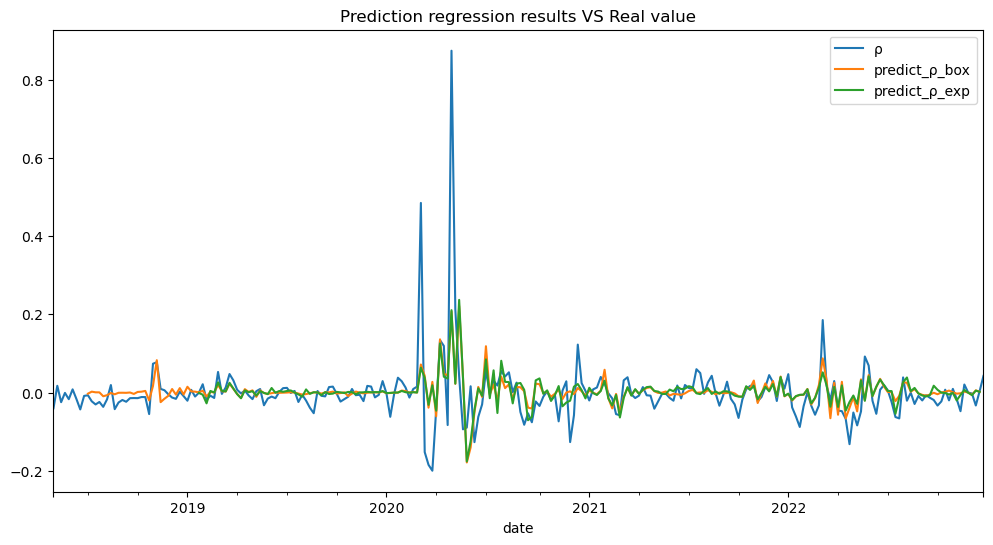

In [244]:
df_luv[['\u03C1','predict_'+'\u03C1'+'_box','predict_'+'\u03C1'+'_exp']].plot(title= "Prediction regression results VS Real value",figsize = (12,6));

* **Statistical properties**

The skewness and kurtosis of the residuals of a regression model can provide useful information about the distribution of the residuals, which is important for evaluating the assumptions of the regression analysis. 

According to the following statistical results of regression residuals q, we could find out that the distributions of residuals do not differ significantly. Both of the regression residuals have positive skewness and kurtosis values, which means that the distributions of the residuals are skewed to the right, meaning that there are more extreme negative values than extreme positive values, and the distributions have heavier tails than a normal distribution, meaning that there are more extreme values than would be expected from a normal distribution. 

Neither of the two regression models achieved a good performance, boxcar regression result is a bit better than discounted least squares regression, with a higher R-squared value of 0.273318.

In [269]:
performance_metrics(df_luv,df_box_q,df_exp_q)

,Count,Mean,Vol,Skewness,Kurtosis,R-squared
Boxbar (K = 10),234,-0.004295,0.068618,4.762308,45.126636,0.273318
Discounted Least Squares (Half life = 9),205,-0.00364,0.073327,4.434644,38.774867,0.263085


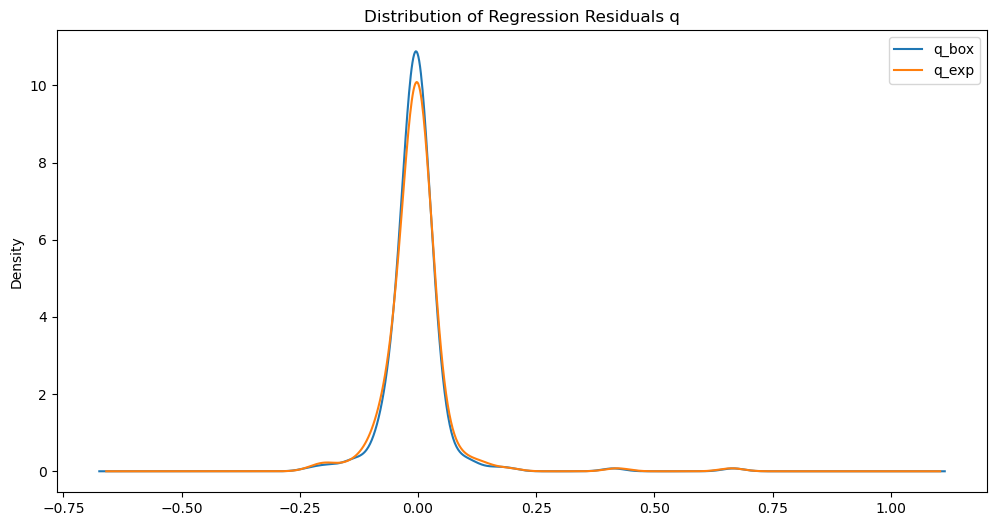

In [268]:
df_luv[['q_box','q_exp']].plot(title= "Distribution of Regression Residuals q" ,figsize = (12,6),kind='kde');

#### **Possible reasons behind the performance**

There are several reasons which may lead to the failure of predictive regression models.

**1.Influence of historical events.** The first half of 2020 was marked by several unexpected and significant events that could have impacted the performance of predictive regression models. Some of the most significant events that could have led to the failure of predictive regression models during this period include:

* COVID-19 Pandemic: The outbreak of the COVID-19 pandemic in early 2020 had a significant impact on the global economy and financial markets. The pandemic led to widespread lockdowns and reduced economic activity, which in turn caused significant disruptions in financial markets. Predictive regression models that were developed based on historical data prior to the pandemic may have been less effective in predicting market movements during the pandemic.

* Oil Price Collapse: In April 2020, the price of oil collapsed, with the WTI crude oil futures contract falling to negative values for the first time in history. This was due to a combination of oversupply and reduced demand as a result of the COVID-19 pandemic. Predictive regression models that were developed based on historical data that did not include such extreme events might have failed to predict the sudden and significant drop in oil prices.

* Political Instability: The first half of 2020 was marked by significant political instability, including the ongoing US-China trade war and the US presidential election. These events could have impacted the performance of predictive regression models, particularly those that were developed based on historical data that did not include such political events.

* Unprecedented Central Bank Intervention: In response to the economic disruptions caused by the COVID-19 pandemic, central banks around the world implemented unprecedented levels of monetary and fiscal stimulus. This could have impacted the performance of predictive regression models, particularly those that were developed based on historical data that did not include such significant levels of central bank intervention.

**2.Potential drawbacks of predictive regression models.** For the boxcar regression model, it might ignore the influence of older observations. For the discounted least squares regression model, one potential issue is that the discount factor must be chosen in advance, which can be difficult to do in practice. 


**3.Lack of indicators.** We are only using one indicator, equity return residual, to predict the CDS return spread residual. CDS return spread residual could be influenced by several factors actually, as a result, the performance of regression models is not satisfactory. Possibly it is also due to this reason, discounted least squares regression model failed to outperm boxcar regression model as I expected.

## Conclusion

In this study, I constructed a two-stage regression for predicting hedged CDS spread returns using two methods, **boxcar and discounted least squares regression**, for the predictive phase, and compare the two. Discussions,analysis and results are as follows.

* The distributions of residuals do not differ significantly. Both of the regression residuals have distributions skewed to the right, and heavier tails than a normal distribution, which indicate a higher level of volatility.

* Neither of the two regression models achieved a good performance, boxcar regression result is a bit better than discounted least squares regression, with a higher R-squared value of 0.273318.

* The regression models failed to accurately predict the sharp fluctuations in CDS return spread residual in the first half of year 2020. The bad performance of models could be attributed to influence of historical events, potential drawbacks of models, and lack of indicators.